In [12]:
import datetime
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

ROOT_DIR = str(Path().resolve().parent)
sys.path.append(f"{ROOT_DIR}/src/")
plt.style.use(f'{ROOT_DIR}/notebooks/project.mplstyle')

# Running on Genomes

In [7]:
contig_filepath = f"{ROOT_DIR}/tests/test_data/GCA_000172155.1_ASM17215v1_genomic.fna.gz"
protein_filepath = f"{ROOT_DIR}/tests/test_data/GCA_000172155.1_ASM17215v1_protein.faa.gz"

## Prediction of growth conditions

In [8]:
from predict_physicochemistry import predict_physicochemistry

genome_features, predictions = predict_physicochemistry(
        fna_path=contig_filepath,
        faa_path=protein_filepath,
        features_json=None,
        instructions_filename=f"{ROOT_DIR}/models/instructions.json",
        #save_intermediate=False,
        #output_prefix='test',
    )

pd.DataFrame(predictions).T

,nt_length,pur_pyr_transition_freq,nt_C,nt_A,total_proteins,total_protein_length,pis_acidic,pis_neutral,pis_basic,pis_3_4,...,aa_G,aa_A,aa_H,aa_E,aa_R,aa_Q,aa_N,aa_F,aa_W,protein_coding_density
all,8220859.0,0.479697,0.603115,0.396885,6519.0,2366909.0,0.198803,0.491486,0.309710,0.0,...,0.079598,0.102065,0.024495,0.061521,0.065069,0.036957,0.028806,0.037722,0.016581,0.863745
extracellular_soluble,NaN,NaN,NaN,NaN,635.0,285520.0,0.215748,0.615748,0.168504,0.0,...,0.090683,0.101415,0.019848,0.059177,0.051978,0.037882,0.035796,0.035310,0.015685,NaN
intracellular_soluble,NaN,NaN,NaN,NaN,5336.0,1921398.0,0.211394,0.501874,0.286732,0.0,...,0.077249,0.100460,0.025459,0.065529,0.068612,0.038291,0.028400,0.035935,0.015833,NaN
membrane,NaN,NaN,NaN,NaN,548.0,159991.0,0.056569,0.246350,0.697080,0.0,...,0.087605,0.116382,0.019158,0.029767,0.047797,0.025121,0.020163,0.055038,0.026177,NaN
diff_extra_intra,NaN,NaN,NaN,NaN,-4701.0,-1635878.0,0.004354,0.113874,-0.118228,0.0,...,0.013435,0.000955,-0.005611,-0.006352,-0.016634,-0.000409,0.007396,-0.000625,-0.000148,NaN


## Measure Genome Features

### 1 Protein Sequence

In [9]:
from protein import Protein

sequence = ''.join("""MAAQDVKQQTPYRVIQLEWDAEKGERNEAVGNFDELVTHHPKSNSDAHLVDGKVVGGQAG
RTLGVVGGEIQEIEVSKAGKDYGLRPDQVLLKKDFMLEDSRLPSGPSSRSLDVPSPVAGV
VGTVNTSKGLVDVLDREGGDVILRVRHMSPLHVKAGDQVEYGQALGVQGKQATGAIHVHM
EVDSRYYQHYENYVGDLVSGRLSIDAERRDRGIEPRPFVDDGTIRIGGSSEMVQKVQQTL
NAEGYRGADNQPLQEDGVYRLSMQAAVINYQQAHGLSQTGDIDPATLQQIAPRTFPPELN
REDHNATPTYRNLQGAVPSQDPLHRQAEEDVRRLEQSLGRDYDDNSARLAASSAHLAKAN
GLTQIDHVVLSNQTAAVGKGENVFVVQGALDNPAHLMAHMKTSDAIAQPVEQSLSQLQTL
SETQRQQQAQQQSQQQDQQQLSAPQHRMV""".split('\n'))

protein = Protein(sequence)
protein.protein_metrics()

{'pi': 5.382106971740723,
 'zc': 0.19821826280623608,
 'nh2o': 0.07137639198218272,
 'gravy': -0.6514476614699332,
 'thermostable_freq': 0.356347438752784,
 'length': 449,
 'is_exported': False,
 'aa_M': 0.0200445434298441,
 'aa_A': 0.08463251670378619,
 'aa_Q': 0.10690423162583519,
 'aa_D': 0.0757238307349666,
 'aa_V': 0.0935412026726058,
 'aa_K': 0.0334075723830735,
 'aa_T': 0.0400890868596882,
 'aa_P': 0.0467706013363029,
 'aa_Y': 0.026726057906458798,
 'aa_R': 0.062360801781737196,
 'aa_I': 0.031180400890868598,
 'aa_L': 0.08240534521158129,
 'aa_E': 0.05790645879732739,
 'aa_W': 0.0022271714922048997,
 'aa_G': 0.08685968819599109,
 'aa_N': 0.035634743875278395,
 'aa_F': 0.011135857461024499,
 'aa_H': 0.035634743875278395,
 'aa_S': 0.066815144766147}

### 1 Signal Peptide Prediction

In [22]:
from signal_peptide import SignalPeptideHMM

partial_sequence = 'MNKTLIAAAVAGIVLLASNAQAQTVPEGYQLQQVLMMSRHNLRAPLANNG'

signal_peptide_model = SignalPeptideHMM()
is_exported, signal_end_index = signal_peptide_model.predict_signal_peptide(partial_sequence)
signal_peptide = partial_sequence[:signal_end_index+1]
is_exported, signal_peptide

(True, 'MNKTLIAAAVAGIVLLASNAQA')

### 1 DNA Sequence


In [10]:
from dna import DNA

sequence = "GGATGGACGGAGGAATTCCTCAAGGAAGTCGGGCCCGCGCTGGTGGTACTCGGTCCAGGCTTCTTGCACGAAGAAGTCTCCGACCGCGCCTCTCTCCACCCTCCTGGCAAAATCGGCCAGTGACTTGATGCCGATGTGGTAGATGAAGCCGGTGTCGAGTACGCCCTTGGCGAAGGTCGGGTCCGCCAGCCTCTCGGGAAAATTTTCTTCGATGTTCAGATAGTAGCCGCGCATGCTGACGCCACGGCTATCTAAAGTGAACATTCCGTCCTTCAGAATGCAATCGGCATGGTGCCAAAATCCAGAGCCCACCGCGCTGGCAATCTTGTTGTCGTCAACTGCGTCGGATCGGACGAGGCACTTCGTGAACGGCGCCGGCAATTCGGACCGTCGAGTGTAATTACGGATTGCGGACCCAGACGGGCGCGTGGCGTGGCCGTTATGCCCAGCATTGACGGAGAACAGGTGGATTGCCCCCACTCCACCCGGAAAGCGTGAGATAAACTCTCGGATCGTGTCGTCGTTGCGCAGTAAAATAAATTCGTCAACATCGAGAAATATGTAATTACGGCTCAGATGTTTAAA"
dna = DNA(sequence)
dna.nucleotide_metrics()

{'nt_length': 585,
 'pur_pyr_transition_freq': 0.4897260273972603,
 'nt_C': 0.558974358974359,
 'nt_A': 0.441025641025641}

### All Protein and DNA Sequences

In [13]:
from genome import Genome
from signal_peptide import SignalPeptideHMM


genome_calc = Genome(
    contig_filepath=contig_filepath, 
    protein_filepath=protein_filepath,
)

print(datetime.datetime.now())
genome_features = genome_calc.genome_metrics()
print(datetime.datetime.now())

2023-11-28 15:05:02.667570
2023-11-28 15:05:07.184555


In [14]:
genome_features.keys()

dict_keys(['all', 'extracellular_soluble', 'intracellular_soluble', 'membrane', 'diff_extra_intra'])

In [15]:
df_genome = pd.DataFrame(genome_features)
df_genome.head(30)

,all,extracellular_soluble,intracellular_soluble,membrane,diff_extra_intra
nt_length,8.220859e+06,NaN,NaN,NaN,NaN
pur_pyr_transition_freq,4.796972e-01,NaN,NaN,NaN,NaN
nt_C,6.031152e-01,NaN,NaN,NaN,NaN
nt_A,3.968848e-01,NaN,NaN,NaN,NaN
total_proteins,6.519000e+03,635.000000,5.336000e+03,548.000000,-4.701000e+03
total_protein_length,2.366909e+06,285520.000000,1.921398e+06,159991.000000,-1.635878e+06
pis_acidic,1.988035e-01,0.215748,2.113943e-01,0.056569,4.353729e-03
pis_neutral,4.914864e-01,0.615748,5.018741e-01,0.246350,1.138740e-01
pis_basic,3.097101e-01,0.168504,2.867316e-01,0.697080,-1.182277e-01
pis_3_4,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00


### All Proteins

In [16]:
protein_data = genome_calc.protein_data()
df_proteins = pd.DataFrame(protein_data).T
df_proteins

,pi,zc,nh2o,gravy,thermostable_freq,length,is_exported,aa_M,aa_S,aa_L,...,aa_C,aa_G,aa_A,aa_H,aa_E,aa_R,aa_Q,aa_N,aa_F,aa_W
ABIZ01000001.1_1,7.551992,-0.179457,0.014524,-0.33754,0.386581,626,False,0.025559,0.059105,0.089457,...,0.015974,0.08147,0.087859,0.017572,0.070288,0.063898,0.044728,0.031949,0.031949,0.01278
ABIZ01000001.1_2,11.364825,-0.744643,0.070964,0.251786,0.464286,56,False,0.017857,0.089286,0.125,...,0.017857,0.107143,0.089286,0.017857,0.017857,0.107143,NaN,0.035714,0.017857,0.035714
ABIZ01000001.1_3,6.49581,-0.276424,-0.020354,-0.144702,0.39404,302,False,0.023179,0.046358,0.112583,...,0.016556,0.092715,0.096026,0.043046,0.062914,0.05298,0.019868,0.039735,0.029801,0.013245
ABIZ01000001.1_4,6.166826,-0.120446,-0.054786,-0.380501,0.395543,359,False,0.022284,0.061281,0.094708,...,0.011142,0.075209,0.075209,0.038997,0.066852,0.064067,0.030641,0.050139,0.038997,0.011142
ABIZ01000001.1_5,5.399329,-0.281062,0.052735,-0.257522,0.411504,226,False,0.00885,0.070796,0.132743,...,0.022124,0.070796,0.110619,0.00885,0.070796,0.084071,0.053097,0.017699,0.030973,0.022124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ABIZ01000001.1_6515,9.24749,-0.947007,-0.111161,0.443796,0.394161,137,False,0.043796,0.051095,0.109489,...,0.007299,0.072993,0.153285,0.014599,0.021898,0.065693,0.029197,0.007299,0.058394,0.029197
ABIZ01000001.1_6516,8.159264,0.033143,0.083814,-0.695714,0.414286,70,False,0.014286,0.057143,0.114286,...,NaN,0.057143,0.057143,0.042857,0.1,0.071429,0.071429,0.057143,0.028571,NaN
ABIZ01000001.1_6517,5.395009,-0.4275,0.021831,-0.223529,0.433824,136,False,0.036765,0.051471,0.132353,...,0.029412,0.095588,0.066176,0.014706,0.080882,0.095588,0.051471,0.014706,0.029412,0.022059
ABIZ01000001.1_6518,4.872716,-0.37697,-0.011582,-0.013636,0.4,330,False,0.045455,0.060606,0.075758,...,0.024242,0.078788,0.087879,0.021212,0.075758,0.054545,0.018182,0.036364,0.036364,0.015152


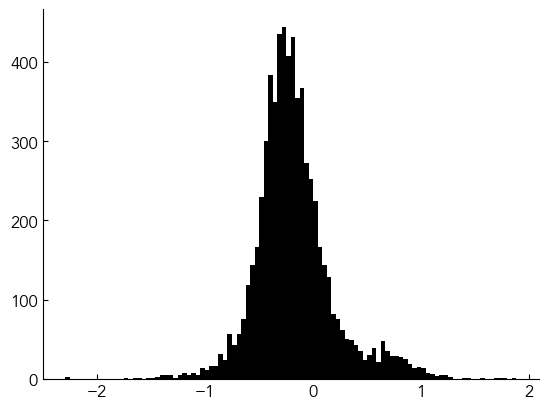

In [17]:
x = 'gravy'

X = df_proteins[x].values 

fig, ax = plt.subplots()
ax.hist(X, bins=100)
#ax.axvline(0.5)

plt.show()

# Model Training

## Balancing a Dataset Phylogenetically

In [ ]:
from download_training_data import ComputeBacDiveTraits
from partition_training_data import PhylogeneticPartition


## Balancing a Data Numerically

## Creating Cross-Validation Sets